# Setting and Load library

In [1]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import librosa
import librosa.display

In [2]:
########################################################################
# setup STD I/O
########################################################################
"""
Standard output is logged in "baseline.log".
"""
import logging

log_filename = 'MY_EDA.log'

logging.basicConfig(level=logging.DEBUG, filename=log_filename)
logger = logging.getLogger(' ')
handler = logging.StreamHandler()
formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)

In [3]:
BASE_PATH = "/media/hiroki/working/research/dcase2020/datasets/DCASE2"
datasets_list = os.listdir(BASE_PATH)
print("datasets : ", datasets_list)

SPECIES_PATH = BASE_PATH + '/dev_data'
species_list = os.listdir(SPECIES_PATH)
print("species : ", species_list)

TEMPLATE_PATH = SPECIES_PATH + '/' + species_list[0]
temprate_list = os.listdir(TEMPLATE_PATH)
print("train/validation/test : ", temprate_list)

DATA_PATH = TEMPLATE_PATH + '/' + temprate_list[0]
dataname_list = os.listdir(DATA_PATH)
dataname_list = sorted(dataname_list)
print("dataname_example : ", dataname_list[0])

datasets :  ['add_dev_data', 'dev_data', 'eval_test']
species :  ['fan', 'pump', 'slider', 'ToyCar', 'ToyConveyor', 'valve']
train/validation/test :  ['test', 'train', 'train_anomaly']
dataname_example :  anomaly_id_00_00000018.wav


In [4]:
dataname_list[0]

'anomaly_id_00_00000018.wav'

In [5]:
def file_load(wav_name, mono=False):
    """
    load .wav file.

    wav_name : str
        target .wav file
    sampling_rate : int
        audio file sampling_rate
    mono : boolean
        When load a multi channels file and this param True, the returned data will be merged for mono data

    return : numpy.array( float )
    """
    try:
        return librosa.load(wav_name, sr=None, mono=mono)
    except:
        logger.error("file_broken or not exists!! : {}".format(wav_name))

In [6]:
def file_to_vector_array(file_name,
                         n_mels=128,
                         frames=5,
                         n_fft=1024,
                         hop_length=512,
                         power=2.0):
    """
    convert file_name to a vector array.

    file_name : str
        target .wav file

    return : np.array( np.array( float ) )
        vector array
        * dataset.shape = (dataset_size, feature_vector_length)
    """
    # 01 calculate the number of dimensions
    dims = n_mels * frames

    # 02 generate melspectrogram using librosa
    y, sr = file_load(file_name)
    mel_spectrogram = librosa.feature.melspectrogram(y=y,
                                                     sr=sr,
                                                     n_fft=n_fft,
                                                     hop_length=hop_length,
                                                     n_mels=n_mels,
                                                     power=power)

    # 03 convert melspectrogram to log mel energy
    log_mel_spectrogram = 20.0 / power * np.log10(mel_spectrogram + sys.float_info.epsilon)

    # 04 calculate total vector size
    vector_array_size = len(log_mel_spectrogram[0, :]) - frames + 1

    # 05 skip too short clips
    if vector_array_size < 1:
        return np.empty((0, dims))

    # 06 generate feature vectors by concatenating multiframes
    vector_array = np.zeros((vector_array_size, dims))
    for t in range(frames):
        vector_array[:, n_mels * t: n_mels * (t + 1)] = log_mel_spectrogram[:, t: t + vector_array_size].T

    return vector_array

In [7]:
# normal
audio_path_0_0 = DATA_PATH + '/' + dataname_list[-1]
y_0_0, sr_0_0 = file_load(audio_path_0_0) # wav, sampling_rate

# normal
audio_path_0_1 = DATA_PATH + '/' + dataname_list[-2]
y_0_1, sr_0_1 = file_load(audio_path_0_1) # wav, sampling_rate

# anomaly
audio_path_1_0 = DATA_PATH + '/' + dataname_list[0]
y_1_0, sr_1_0 = file_load(audio_path_1_0)

# anomaly
audio_path_1_1 = DATA_PATH + '/' + dataname_list[1]
y_1_1, sr_1_1 = file_load(audio_path_1_1)

In [8]:
vector_array_sample1 = file_to_vector_array(file_name=audio_path_0_0)

In [9]:
vector_array_sample1.shape

(309, 640)

In [10]:
y, sr = file_load(audio_path_1_0)

In [11]:
melspectrogram = librosa.feature.melspectrogram(y=y,
                                                 sr=sr,
                                                 n_fft=1024,
                                                 hop_length=512,
                                                 n_mels=128,
                                                 power=2.0)

In [12]:
melspectrogram.shape

(128, 313)

In [13]:
log_melspectrogram = 20.0 / 2.0 * np.log10(melspectrogram + sys.float_info.epsilon)

In [14]:
log_melspectrogram.shape

(128, 313)

In [15]:
frames = 5
n_mels = 128
dims = n_mels * frames
vector_array_size = len(log_melspectrogram[0, :]) - frames + 1

In [16]:
vector_array = np.zeros((vector_array_size, dims))
    for t in range(frames):
        vector_array[:, n_mels * t: n_mels * (t + 1)] = log_mel_spectrogram[:, t: t + vector_array_size].T

IndentationError: unexpected indent (<ipython-input-16-b40836488176>, line 2)

## waveform(raw)

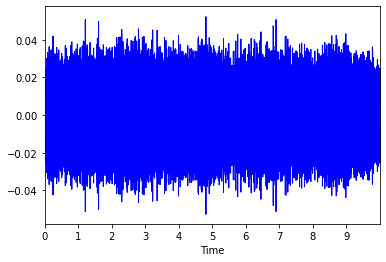

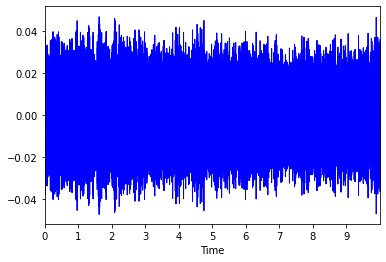

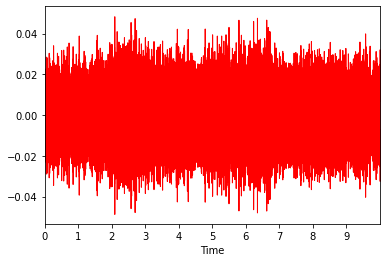

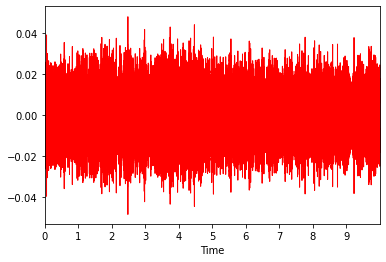

In [17]:
librosa.display.waveplot(y_0_0, sr=sr_0_0, color='blue')
plt.show()
librosa.display.waveplot(y_0_1, sr=sr_0_1, color='blue')
plt.show()
librosa.display.waveplot(y_1_0, sr=sr_1_0, color='red')
plt.show()
librosa.display.waveplot(y_1_1, sr=sr_1_1, color='red')
plt.show()

## melspectrogram

In [18]:
# normal
S0_0 = librosa.feature.melspectrogram(y_0_0,
                                   n_mels=64,
                                   n_fft=1024,
                                   hop_length=512,
                                   power=2.0)
log_S0_0 = librosa.amplitude_to_db(S0_0, ref=np.max)
# normal
S0_1 = librosa.feature.melspectrogram(y_0_1,
                                   n_mels=64,
                                   n_fft=1024,
                                   hop_length=512,
                                   power=2.0)
log_S0_1 = librosa.amplitude_to_db(S0_1, ref=np.max)
# anomaly
S1_0 = librosa.feature.melspectrogram(y_1_0,
                                   n_mels=64,
                                   n_fft=1024,
                                   hop_length=512,
                                   power=2.0)
log_S1_0 = librosa.amplitude_to_db(S1_0, ref=np.max)
# anomaly
S1_1 = librosa.feature.melspectrogram(y_1_1,
                                   n_mels=64,
                                   n_fft=1024,
                                   hop_length=512,
                                   power=2.0)
log_S1_1 = librosa.amplitude_to_db(S1_1, ref=np.max)

/home/hiroki/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/home/hiroki/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


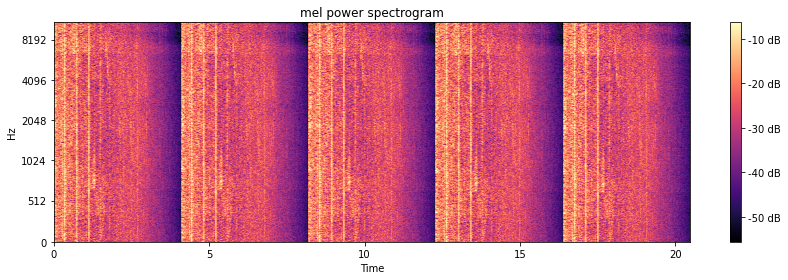

In [19]:
plt.figure(figsize=(12, 4))
librosa.display.specshow(vector_array_sample1, sr=sr_0_0, x_axis='time', y_axis='mel')
plt.title('mel power spectrogram')
plt.colorbar(format='%02.0f dB')
plt.tight_layout()
plt.show()

normal plot


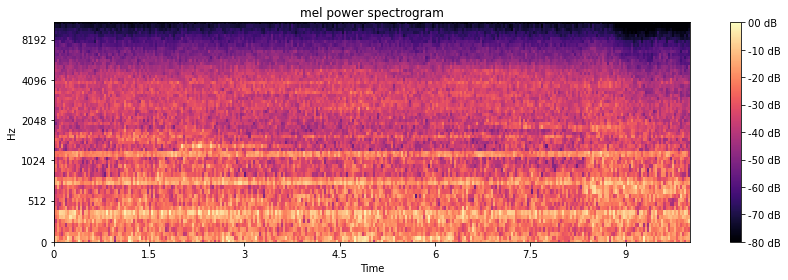

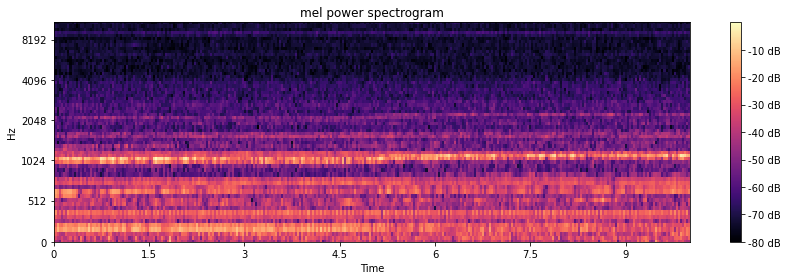

anomaly plot


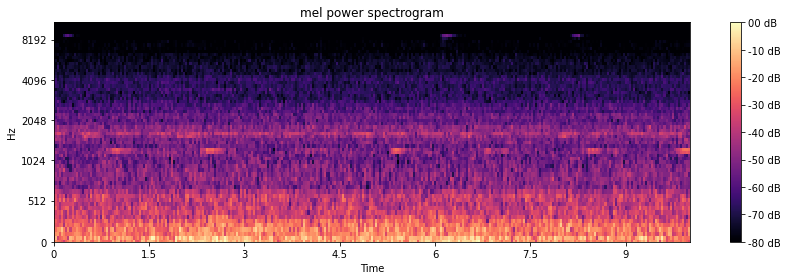

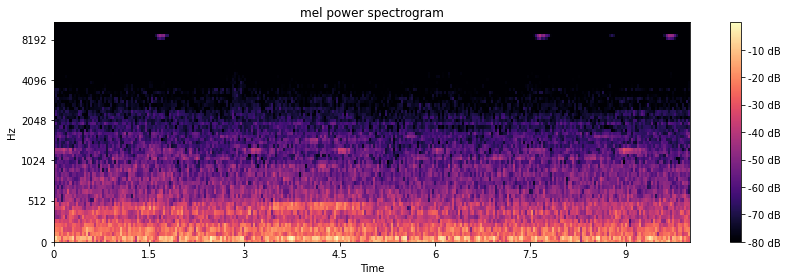

In [20]:
print("normal plot")
plt.figure(figsize=(12, 4))
librosa.display.specshow(log_S0_0, sr=sr_0_0, x_axis='time', y_axis='mel')
plt.title('mel power spectrogram')
plt.colorbar(format='%02.0f dB')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 4))
librosa.display.specshow(log_S0_1, sr=sr_0_1, x_axis='time', y_axis='mel')
plt.title('mel power spectrogram')
plt.colorbar(format='%02.0f dB')
plt.tight_layout()
plt.show()

print("anomaly plot")
plt.figure(figsize=(12, 4))
librosa.display.specshow(log_S1_0, sr=sr_1_0, x_axis='time', y_axis='mel')
plt.title('mel power spectrogram')
plt.colorbar(format='%02.0f dB')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 4))
librosa.display.specshow(log_S1_1, sr=sr_1_1, x_axis='time', y_axis='mel')
plt.title('mel power spectrogram')
plt.colorbar(format='%02.0f dB')
plt.tight_layout()
plt.show()

In [21]:
np.savetxt('ano_sample.csv', log_S1_1, delimiter=',')

In [23]:
from scipy.spatial import procrustes

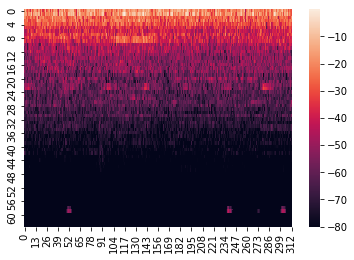

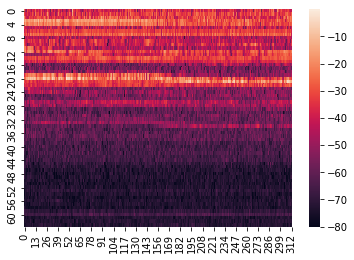

In [41]:
sns.heatmap(log_S1_1)
plt.show()
sns.heatmap(log_S0_1)
plt.show()

In [42]:
mtx1, mtx2, disparity = procrustes(log_S1_1, log_S0_1)

<AxesSubplot:>

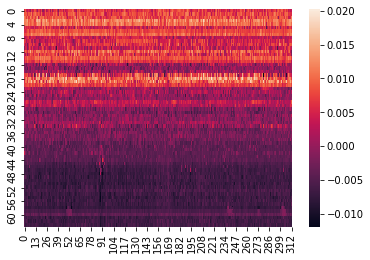

In [43]:
sns.heatmap(mtx2)